## STEP 0. 라이브러리 불러오기

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import os
import re
import urllib
import numpy as np
import matplotlib.pyplot as plt
import time
import random

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## STEP 1. 데이터 수집하기

---
송영숙님이 공개한 한국어 챗봇데이터를 사용하여 만들어봅니다.

- [송영숙님 github](https://github.com/songys/Chatbot_data)

In [ ]:
# 바로 다운로드하기
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatbotData.csv")


('ChatbotData.csv', <http.client.HTTPMessage at 0x7f0f0f020e10>)

In [ ]:
data = pd.read_csv('ChatbotData.csv')

In [ ]:
print('data 모양 : ', data.shape)
print('data 갯수 : ', len(data))
data.head()

data 모양 :  (11823, 3)
data 갯수 :  11823


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


총 1183개로 이뤄져 있으며, Q, A, label로 이뤄져 있네요!  

토크나이져를 하기 전에 전처리를 해줍니다.

## STEP 2. 데이터 전처리 하기

In [ ]:
############결측치 확인############
data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

결측치는 없음을 확인했다. 

label의 비율은 어떤지 한번 확인해보자. 

In [ ]:
data['label'].value_counts()

0    5290
1    3570
2    2963
Name: label, dtype: int64

상기 label값은 하기와 같이 레이블링 되었다고한다.
- 일상다반사 0
- 이별(부정) 1 
- 사랑(긍정) 2  

역시 일상얘기보단 사랑/이별이 살짝 더 많은 것을 알 수 있다. 인생이란 사랑과 이별의 연속~~~

질문의 최소 길이 : 1
질문의 최대 길이 : 15
질문의 평균 길이 : 3.587414361837097
대답의 최소 길이 : 1
대답의 최대 길이 : 21
대답의 평균 길이 : 3.6936479742874058


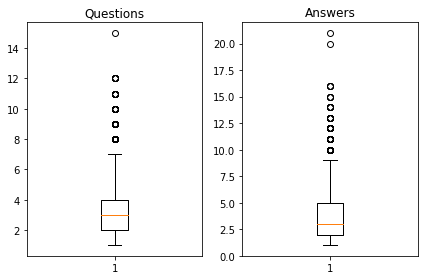

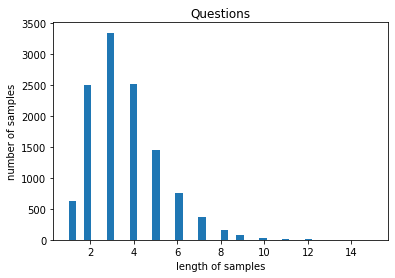

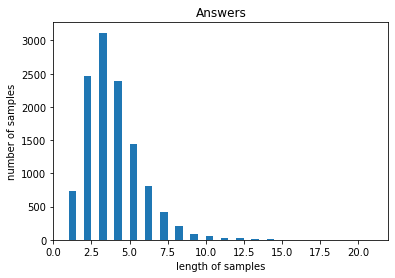

In [ ]:
###########길이 분포 출력###############
questions_len = [len(q.split()) for q in data['Q']]
answers_len = [len(a.split()) for a in data['A']]

print('질문의 최소 길이 : {}'.format(np.min(questions_len)))
print('질문의 최대 길이 : {}'.format(np.max(questions_len)))
print('질문의 평균 길이 : {}'.format(np.mean(questions_len)))
print('대답의 최소 길이 : {}'.format(np.min(answers_len)))
print('대답의 최대 길이 : {}'.format(np.max(answers_len)))
print('대답의 평균 길이 : {}'.format(np.mean(answers_len)))

plt.subplot(1,2,1)
plt.boxplot(questions_len)
plt.title('Questions')
plt.subplot(1,2,2)
plt.boxplot(answers_len)
plt.title('Answers')
plt.tight_layout()
plt.show()

plt.title('Questions')
plt.hist(questions_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Answers')
plt.hist(answers_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
#긴 질문 / 답변 확인
curious_questions = [idx for idx, val in enumerate(questions_len) if val >= 12 ]
print(curious_questions)

curious_answer = [idx for idx, val in enumerate(answers_len) if val >= 16 ]
print(curious_answer)

[5567, 9273, 9276, 9519, 10052, 11011, 11248, 11810]
[9659, 9884, 10258, 10728, 10780, 10808]


In [ ]:
print('===================긴 질문에대한 문답==================')
for i in curious_questions:
    print(data.loc[i]) 

print('\n===================긴 답변에대한 문답==================')
for i in curious_answer:
    print(data.loc[i])

===================긴 질문에대한 문답==================
Q        괜찮은 줄 알았는데 남자가 생겼단 말에 마음이 또 다시 덜컥 내려 앉네
A                         이젠 떠나간 사람 때문에 괴로워 말아요.
label                                          1
Name: 5567, dtype: object
Q        남자들은 여자가 자기 좋아하는 거 알게 되면 어떻게 해? 싫지 않다면 받아줘?
A                                 그분도 좋아한다면 받아줄 거예요.
label                                              2
Name: 9273, dtype: object
Q        남자들은 좋아하는 여자가 자기보다 능력이 좋은 경우에 아무리 좋아해도 마음 접고 포...
A                                         절대 능력만 중요하지 않아요.
label                                                    2
Name: 9276, dtype: object
Q        내가 좋아하는 애가 날 좋아하는 것 같으면 갑자기 정 떨어지고 뭔가 싫어짐
A                                        어떤 심리일까요.
label                                            2
Name: 9519, dtype: object
Q        서로 좋아하는 것 같은데 내가 자존심 때문에 자꾸 관심 없는 척하게 돼.
A                             사랑 앞에 자존심은 소용이 없어요.
label                                           2
Name: 10052, dtype: object
Q        제가 좋아하는 사람이 맘 잡고 공부해야할 것 같

크... 역시 사랑문제엔 장문이 나오는구만~~  
재밌네여 계속해서 진행해줍니다

In [ ]:
#짧은 질문 / 답변 확인
curious_questions = [idx for idx, val in enumerate(questions_len) if val <= 1]
print(curious_questions)

curious_answer = [idx for idx, val in enumerate(answers_len) if val <= 1 ]
print(curious_answer)

[38, 82, 83, 89, 93, 94, 100, 118, 120, 123, 162, 199, 238, 250, 262, 293, 295, 296, 342, 360, 367, 401, 444, 614, 989, 1022, 1028, 1040, 1053, 1054, 1057, 1138, 1156, 1157, 1158, 1230, 1240, 1243, 1319, 1382, 1400, 1420, 1423, 1450, 1511, 1516, 1527, 1540, 1551, 1558, 1732, 1752, 1763, 1779, 1780, 1799, 1826, 1832, 1838, 1880, 1881, 1884, 1904, 1905, 1913, 1914, 1916, 1957, 1972, 2000, 2001, 2006, 2007, 2013, 2014, 2021, 2103, 2119, 2123, 2127, 2128, 2134, 2135, 2156, 2173, 2176, 2178, 2179, 2180, 2242, 2251, 2254, 2319, 2351, 2389, 2482, 2517, 2532, 2533, 2598, 2645, 2651, 2692, 2696, 2764, 2769, 2789, 2794, 2796, 2797, 2801, 2802, 2804, 2817, 2827, 2922, 2949, 2950, 2951, 2952, 2967, 2995, 3001, 3025, 3052, 3053, 3057, 3058, 3129, 3241, 3242, 3376, 3456, 3457, 3492, 3545, 3553, 3556, 3564, 3596, 3610, 3620, 3621, 3628, 3630, 3632, 3633, 3671, 3696, 3719, 3752, 3813, 3842, 3856, 3866, 3868, 3878, 3880, 3921, 3922, 3934, 3952, 3966, 3967, 3971, 4020, 4032, 4042, 4061, 4104, 4105, 4170

In [ ]:
print('===================짧은 질문에대한 문답==================')
print(data.loc[38]) 
print(data.loc[83])
print(data.loc[93])

print('\n===================짧은 답변에대한 문답==================')
print(data.loc[29])
print(data.loc[97])



===================짧은 질문에대한 문답==================
Q                   가출할까?
A        무모한 결정을 내리지 마세요.
label                   0
Name: 38, dtype: object
Q            개강이라니
A        방학이 참 짧죠.
label            0
Name: 83, dtype: object
Q                    개졸려
A        낮잠을 잠깐 자도 괜찮아요.
label                  0
Name: 93, dtype: object

===================짧은 답변에대한 문답==================
Q        가족들 보고 싶어
A             저도요.
label            0
Name: 29, dtype: object
Q        걔는 누굴 닮아서 그런거니?
A                  당신이요.
label                  0
Name: 97, dtype: object


ㅋㅋㅋㅋ 예... 걔는 당신을 닮아 그런걸로...ㅋㅋㅋㅋㅋ  
한단어로 이루어진 문답까지 확인해봤습니다. 재밌네욤

In [ ]:
#########data 중복 유무 확인##########
# Q 열의 중복 유무 확인
print('==================Q 열 중복 확인======================')
print(data['Q'].value_counts())
# A 열의 중복 유무 확인
print('==================A 열 중복 확인======================')
print(data['A'].value_counts())

==================Q 열 중복 확인======================
외로워           4
너무 힘들다        3
올해 왜 이러지      3
사랑을 했다        3
술 먹고 싶어       2
             ..
잘 사니?         1
잘 살고 싶어       1
잘 살고 있겠지?     1
잘 선택한건지       1
힘들어서 결혼할까봐    1
Name: Q, Length: 11662, dtype: int64
==================A 열 중복 확인======================
맛있게 드세요.                    22
제가 있잖아요.                    17
조심하세요.                      14
감기 조심하세요.                   14
직접 물어보세요.                   12
                            ..
좀 더 밝고 신나는 노래 들어보세요.         1
누군가를 잊어야한다는건 정말 힘든 일이죠.      1
새로운 이야기를 시작해보세요.             1
아직도 힘드시군요.                   1
잘 헤어질 수 있는 사이 여부인 거 같아요.     1
Name: A, Length: 7779, dtype: int64


ㅠㅠ...  
Q 값에는 외로워, 너무 힘들다 등이 중복되어 있는 것을 확인할 수 있고,
A 값에는 맛있게 드세요 등 중복값들이 꽤 많아보인다. 하지만 다양한 답변을 주기 어려운 챗봇의 특성상? A 열의 중복은 어쩔 수 없는 것 같다.   

우선 Q에 중복된 값들이 같은 답변을 하고 있는지 확인하고, 답변이 같다면 중복으로 삭제해주도록하자. 


In [ ]:
print (data.loc[data['Q'] == '외로워'])

        Q             A  label
3456  외로워  친구를 사귀어 보세요.      0
3457  외로워     혼자가 아니에요.      0
7261  외로워   제가 곁에 있을게요.      1
7262  외로워     혼자가 아니에요.      1


In [ ]:
print (data.loc[data['Q'] == '사랑을 했다'])

           Q               A  label
9897  사랑을 했다    또 사랑을 할 거예요.      2
9898  사랑을 했다  예쁜 사랑이었길 바랍니다.      2
9899  사랑을 했다         우리가 만나.      2


ㅋㅋ사랑을 했다~ 우리가 만나~  이렇게 같은 질문이지만, 다른 답변일 뿐더러 label의 값도 다른 질문이 있다. 이것을 어떻게 처리해야 좋을지 생각해본다.  
내가 챗봇 이용자라고 했을 때, 같은 질문에 다른 답변을 줄 수 있는 챗봇이 더 좋은 모델이라고 판단되어 중복값은 삭제하지 않고 계속 진행하기로 한다!  

- 뒤에서 **label smoothing**으로 업그래이드 하면 좋을듯하다.
### label smoothing이란?
- label smoothing : 모델이 학습 데이터에 너무 치중하지 않도록 보완하는 기술.  
학습데이터가 깔끔하고 확실한 경우는 필요 없으나, 같은 입력값에서 다른 출력값을 내보낼 때(=noisy할 경우), 도움이 된다고 함.
- one-hot 인코딩이 아니라 작은 수로 표현함으로 정답과의 loss율을 낮춤
- Tensorflow에서는 BinaryCrossentropy와 CategoricalCrossentropy함수에 이미 구현되어 있다고하니, 마지막 loss 함수를 짤때 추가해주자  

`tf.keras.losses.BinaryCrossentropy(
    from_logits=False, label_smoothing=0, reduction=losses_utils.ReductionV2.AUTO,
    name='binary_crossentropy'
)`   

---
### 참고사이트
- [[Tips] 라벨 스무딩을 이용한 모델 성능 개선](https://jeonghwarr.github.io/tips/label_smoothing/)  
- [라벨 스무딩(Label smoothing), When Does Label Smoothing Help?](https://blog.si-analytics.ai/21)
- [Label smoothing: 딥러닝 모델의 일반화와 Calibration 향상을 위한 테크닉](https://3months.tistory.com/465)

## STEP 3.  SubwordTextEncoder 사용하기(tokenize)  

---
1) 해당 실습에서는 내부 단어 토크나이저인 `SubwordTextEncoder`를 사용하여 진행하라고 하였으니 한번 진행해본다.  

2) 그리고 앞선 실습에서 진행한 한국어 형태소 분석기인 `Okt`를 사용하여 tokenize를 진행하여 비교해보자. 

### 3-1) `SubwordTextEncoder`를 사용하여 tokenizing  
---
- `SubwordTextEncoder`란? BPE와 유사한 알고리즘인 Wordpiece Model을 채택하였으며, 패키지를 통해 쉽게 단어들을 서브워드들로 분리할 수 있습니다.

정규 표현식(Regular Expression) 을 사용하여 구두점(punctuation) 을 제거하여 단어를 토크나이징(tokenizing) 하는 일에 방해가 되지 않도록 정제하도록 하자.  

num_words는 샘플의 길이가 짧다보니, 제한을 두지 않고 우선 다 사용해본다.

In [ ]:
#############전처리 함수##############
def preprocess_sentence(sentence):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # 구두점 존재시, 사이에 공백 생성
    # sentence = re.sub(r"[^가-힣?.!,0-9]+", " ", sentence) # (한글,숫자,".", "?", "!", ",")를 제외한 모든 문자를 공백으로 대체
    #상기 re.sub은 굳이 필요없을 것 같아 제외한다.
    sentence = sentence.strip() # 양 끝 공백 삭제
    return sentence

print('전처리함수 만들기 완료:)')

전처리함수 만들기 완료:)


In [ ]:
####### Q / A 값 전처리 해주기########
questions = []
answers = []
for sentence in data['Q']:
    questions.append(preprocess_sentence(sentence))

for sentence in data['A']:
    answers.append(preprocess_sentence(sentence))

print('전처리 완료:)!')

전처리 완료:)!


In [ ]:
###########전처리 잘 됐는지 확인#############
print("질문 전처리 후\n", random.sample(questions, 5))
print("답변 전처리 후\n", random.sample(answers, 5))

질문 전처리 후
 ['마음이 완전히 식은 남자', '왜 남자친구 있는 여자를 내 마음을 흔들지 ?', '아직도 심장이 뛰고있어 .', '새벽 감성', '너무 힘이 들고 내 자신이 한심해']
답변 전처리 후
 ['손재주가 좋으시네요 .', '즐길 수 있을 때 즐기세요 .', '좋은 곳으로 갈 수 있도록 인도해줄 거예요 .', '남보다 하나씩 더 하면 돼요 .', '오래된 건 오래된 대로 매력이 있죠 .']


Q, A값의 전처리가 잘 진행된 것을 볼 수 있습니다.   
이렇게 함으로써 단어를 토크나이징 하는 과정에서 구두점과 붙어있던 단어들을 하나의 단어로 인식하는 것을 방지하였습니다!

In [ ]:
########### 단어장 만들기 #############
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers,
                                                                      target_vocab_size = 2**13)

########### 스타트/엔드 토큰 만들기 #############
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print('START 토큰 번호 : ', [tokenizer.vocab_size])
print('END 토큰 번호 : ', [tokenizer.vocab_size + 1])

########### 스타트/엔드 토큰 반영하여 vocab_size 변경 ############
VOCAB_SIZE = tokenizer.vocab_size + 2
print('최종 VOCAB_SIZE : ', VOCAB_SIZE)


START 토큰 번호 :  [8178]
END 토큰 번호 :  [8179]
최종 VOCAB_SIZE :  8180


In [ ]:
################ 토큰화된 subwords 샘플 출력 ###################
print(tokenizer.subwords[:20])

[' .', ' ?', '거예요', '수_', '게_', '너무_', '더_', '거_', '좋아하는_', '는_', '이_', '을_', '잘_', '도_', ' .  ', '고_', '요', '것_', '많이_', '안_']


신기하게도 마치 형태소로 분리한 것 처럼 토큰화되었다. 

In [ ]:
############### encoding test #################
print(tokenizer.encode(questions[9452]))
print(tokenizer.encode(answers[9452]))

[56, 137, 266, 6012, 8, 37]
[1359, 1327, 1303, 1868, 7, 605, 3, 1]


In [ ]:
print(questions[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']


In [ ]:
############## 토크나이즈 및 패딩 처리 함수 ################
MAX_LEN = np.max(questions_len and answers_len) # Q, A의 둘중의 가장 긴 것을 max-len으로 설정한다.
print("샘플의 최대길이 : ", MAX_LEN)

def tokenize_and_filter(inputs, outputs):
    tokenized_questions, tokenized_answers = [], []
    
    # Q/A 정수 인코딩 후 START/END TOKEN 붙이기
    for (sentence1, sentence2) in zip(inputs, outputs):
        tokenized_inputs = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        tokenized_outputs = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        tokenized_questions.append(tokenized_inputs)
        tokenized_answers.append(tokenized_outputs)

    # 최대길이로 데이터셋 패딩
    tokenized_questions = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_questions, maxlen = MAX_LEN, padding = 'post'
    )
    tokenized_answers = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_answers, maxlen = MAX_LEN, padding = 'post'
    )

    return tokenized_questions, tokenized_answers

print('토크나이즈 및 패딩 함수 완료')


샘플의 최대길이 :  21
토크나이즈 및 패딩 함수 완료


In [ ]:
########### Q / A 토크나이즈 및 패딩 하기 #############
questions, answers = tokenize_and_filter(questions, answers)

In [ ]:
############ Q /A 패딩 잘 됐는지 모양 확인 ###############
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (11823, 21)
답변 데이터의 크기(shape) : (11823, 21)


In [ ]:
print(questions[:5])

[[8178 7915 4207 3060   41 8179    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [8178 7971   47  919 7954  998 1716 8179    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [8178 7973 1435 4653 7954 3652   67 8179    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [8178 7973 1435 4653 7954 1295 3652   67 8179    0    0    0    0    0
     0    0    0    0    0    0    0]
 [8178 8002 8002 7998 7954 4190 8179    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]


음 굿!

### 교사 강요 사용하기


In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000 # 보유 샘플보다 크게해야함 - 왜..?

#디코더는 이전의 target을 다음의 input으로 사용
#이에따라 outputs에서 START_TOKEN 제거

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs' : questions,
        'dec_inputs' : answers[:, :-1]
    },
    {
        'outputs' : answers[:, 1:]
    }))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

print('오토튠?')

오토튠?


## Step 4. 모델 구성하기
---
트랜스포머 모델 구현하기
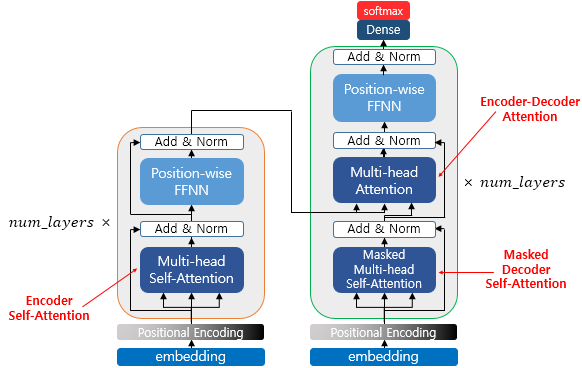

앞서 토크나이즈, 패딩처리하여 embedding 할 준비까지 마쳤으니 상기 그림의 차례대로  
- INCODER
    - positional encoding layer
    - multi-head self-Attention layer  
    ( = Encoder self-attention)
    - add & normalization layer (tf.함수사용)
    - position-wise FFNN layer

- DECODER
    - masked multi-head self-Attention  
    (= masked layermasked decoder self-attention layer)
    - multi-head self-Attention layer  
    ( = encoder-decoder attention layer)
    - dense
    - softmax

층을 만들어 주자

## 1. 인코더 층 만들기

### 1) 포지셔널 인코딩 레이어 설정
---

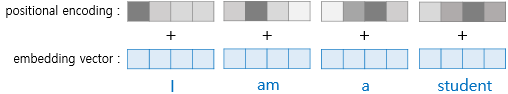

- positional encoding값은 sin과 cos인을 이용하여 위치를 정해줌 -> 값이 -1 ~ 1 사이의 값으로 제한됨

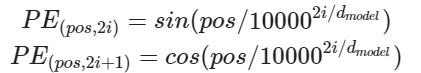

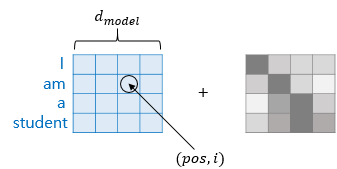

- d_model : 임베딩 벡터의 차원
- pos : 입력 문장에서의 임베딩 벡터의 위치
- i : 임베딩 벡터 내의 차원의 인덱스

In [169]:
############## 포지셔널 인코딩 레이어 ################
# 한번에 들어온 단어들의 위치를 알려주는 벡터(positional Encoding)값을 더해주는 역할

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    ## sin의 각도부분(=pos/10000^2i/d_model)
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    ## 각도 생성
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position = tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model = d_model)
        
        #짝수는 sin
        sines = tf.math.sin(angle_rads[:, 0::2])
        #홀수는 cos
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print('positional encoding layer 완성')

positional encoding layer 완성


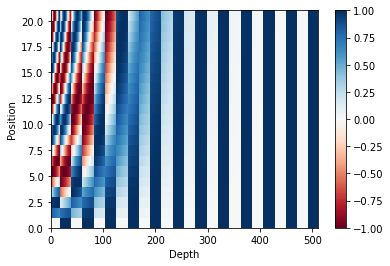

In [170]:
####### 해당 샘플의 최대길이, 워드 임베딩 512의 포지셔널벡터모양 출력 ##########
sample_pos_encoding = PositionalEncoding(MAX_LEN, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

정확히 이해되지는 않지만... 멋있는 그래프가 나왔다...   
sin, cos의 조합으로 값이 -1 ~ 1 사이로 변경되어 위치를 나타내주는 것을 알 수 있다. 

### 2) self Attention
---
- 스케일드 닷 프로덕트 어텐션(=벡터 내적) 함수 구현하기 
    - 트랜스포머는 어텐션에 쿼리, 키, 벨류값을 수식에 넣어 단어간의 유사도를 나타낸다.(그림1) 
    - 먼저 쿼리와 키의값을 내적(=Q와 K의 전치 행렬을 곱함 하여 값을 구한 후(그림2),
    - dk의 제곱근으로 나눠 스케일링을 해주고 벨류값을 곱해 어텐션 벡터를 얻는다. (그림3)

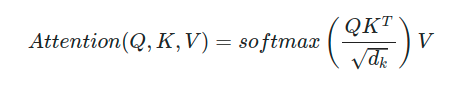

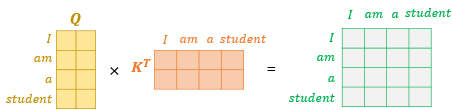


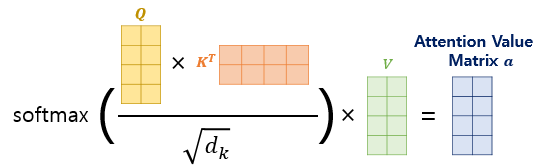

In [172]:
############## 스케일드 닷 프로덕트 어텐션 레이어 ################
def scaled_dot_product_attention(query, key, value, mask):
    #먼저 query와 key를 곱해(내적) 가중치를 구함
    matmul_qk = tf.matmul(query, key, transpose_b=True) # key값의 모양을 바꿔서 곱함

    #가중치를 정규화함
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    #패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    #Softmax 함수 적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    #최종 어텐션은 가중치와 Value의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    
    return output

print('스케일드 닷 프로덕트 어텐션 레이어 완성')

스케일드 닷 프로덕트 어텐션 레이어 완성


### 3) multi attention
---

이제 셀프 어텐션을 멀티로 (다각도로) 분석할 수 있도록 병렬 어텐션 함수를 구현하자  

- 이 병렬 수를 `num_heads` 값으로 넣어준다.
- 기본 (입력 문장 수, 임베딩 벡터 차원(d_model))의 벡터들이 있는데, 트랜스포머는 이렇게 입력된 문장 행렬을 `num_heads`의 수만큼 쪼개서 어텐션을 수행한다. 
- 그럼 어텐션 값이 `num_heads`(병렬수) 만큼 생성되고, 이를 concat하여 하나로 합쳐준다. 
- 그럼 결국 다시 열의 값은 `d_model`의 수로 돌아가게 된다.   
(마치 문제지를 나눠서 푼 후, 마지막에 결과를 합치는 느낌) 


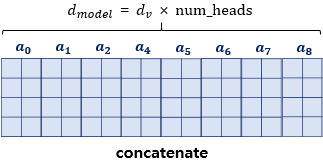  

- 이렇게 병렬로 처리하면, 단어와의 유사도를 다각도로 확인할 수 있는 장점이 있다. 

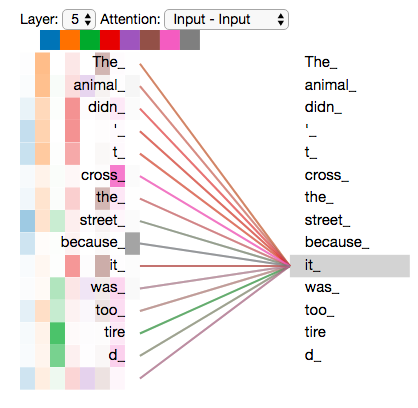  
상기 그림처럼 다각도의 관점을 갖게 되고, 이같이 어텐션을 병렬로 수행하는 것을 'multi-head-attention'이라고 부른다.   

그럼 구현해보자!

In [173]:
################### Multi Head Attention 클래스 ###########################
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name = "multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model을 num_head값으로 나눠 0이 되는 경우에만 진행하도록 0이 아니면 error를 띄워줌
        assert d_model % num_heads == 0

        # d_model 값을 num_head 값으로 나눠 각 어텐션이 처리할 열값을 구한다.
        self.depth = d_model // self.num_heads
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

        #d_model 나눈 값으로 각 attention head에 나눠주기
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        # 단어의 수(query)는 같고, 임베딩만 나누니까 batch_size는 query[0]으로 맞춤 
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용해줍니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        #병렬 연산을 위해 머리를 여러개로 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        #미리 만들어 놓은 스케일드 닷 프로덕트 어텐션 함수를 불러와 각각 연산을 시킵니다.
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 concatenate 해줍니다
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        #최종 결과에 Dense를 한번 적용해 줍니다.???왜???
        outputs = self.dense(concat_attention)

        return outputs

print('multi head attention 구현 완료:)!!!!')

multi head attention 구현 완료:)!!!!


### 4) 마스킹 레이어 만들기
---
- 트랜스포머에선 인코딩에 사용되는 패딩 마스킹(padding masking)
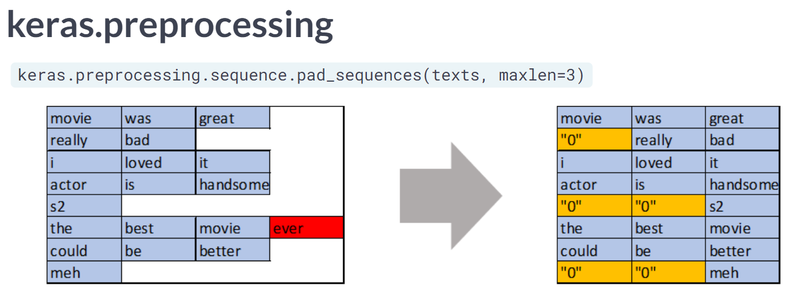
    - 앞 또는 뒤에 0을 넣어 모든 문장의 길이를 최대문장으로 맞춰주는 것
    - 위 그림은 케라스의 pad_sequences()를 사용하여 패딩을 하는 과정을 시각화한 그림
    - 그런데 사실 이렇게 주어진 숫자 0은 실제 의미가 있는 단어가 아니므로 실제 어텐션 등과 같은 연산에서는 제외할 필요가 있음. 패딩 마스킹은 이를 위해 숫자 0인 위치를 체크함.



- 디코딩에 사용되는 look ahead masking이 있음
    - 트랜스포머는 문장이 행렬로 한번에 다 입력되기 때문에, 다음 단어를 가려주어 해당 시점에 출력된 값만 참고할 수 있도록 함

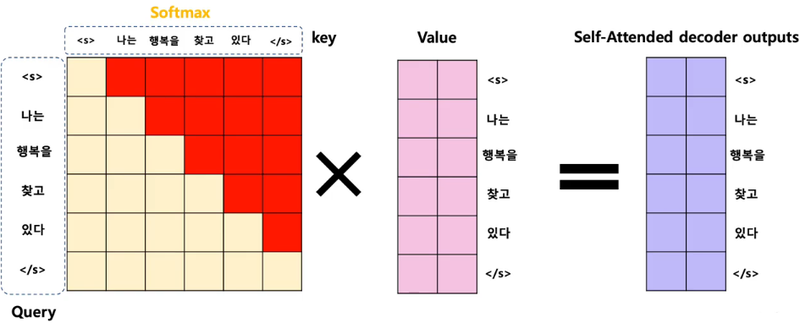

In [174]:
########### 인코더에서 사용할 padding mask ##############
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)

    # 축을 추가하여 (batch_size, 1, 1, sequence length)로 맞춰줌
    return mask[:, tf.newaxis, tf.newaxis, :]

print('패딩 마스킹 함수 완료!')

패딩 마스킹 함수 완료!


In [175]:
############ 디코딩에서 사용할 look ahead mask ##############
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    # x의 사이즈에 맞춰 사선으로 1을 넣은 행렬 만들어줌으로 가림 가능
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    
    #내부적으로 padding mask를 호출하여 0으로 패딩된 부분은 참고하지 않도록 1을 넣어줌
    padding_mask = create_padding_mask(x)

    return tf.maximum(look_ahead_mask, padding_mask)

print('뤀어헫 마슼 완료~:)')

뤀어헫 마슼 완료~:)


### 5) 인코더 층 만들기
---
- 하나의 인코더층은 상기 만들어 놓은 self-attention층과 feed forward neural network 층으로 구성되어 있다.   

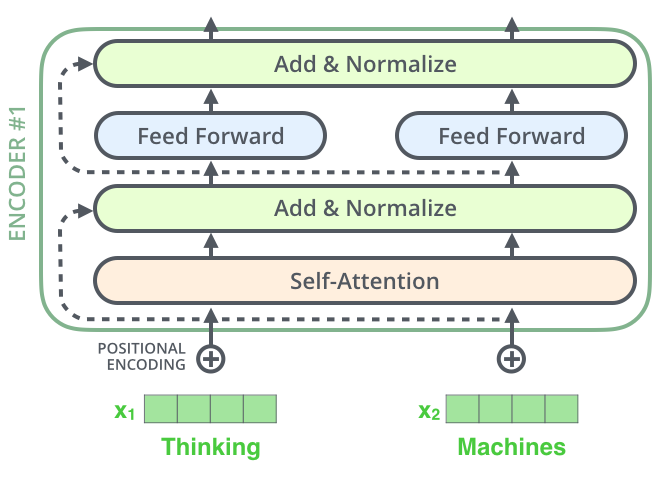

- 이제 함수 내부로 두개의 층을 묶어주도록 하자

In [176]:
################# 인코더 층 #####################
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    #패딩 마스크 (1, 1, sequence length) 에서 seq_len은 가변이니 None으로 논다
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    #첫번째 layer : multi head attention (self attention)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
            })

    #어텐션 후 Dropout과 layer normalization을 넣어 훈련을 도움
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    #두번째 layer : feed foward로 완전 연결
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    #완전 연결 후 Dropout과 layer normalization을 넣어 훈련을 도움
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)
    
    return tf.keras.Model(
        inputs = [inputs, padding_mask], outputs = outputs, name = name
    )

print('인코더 레이어 완성!!!!!!!!!!')
    

인코더 레이어 완성!!!!!!!!!!


### 6) 인코딩 층들 묶어주기

---
인코더 층을 쌓아 인코더 만들기

- 이렇게 구현한 인코더 층을 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성됨

- 트랜스포머는 하이퍼파라미터인 `num_layers` 개수를 넣어 반복해 인코더 층을 쌓습니다.
    - 이는 **인코더의 출력 전/후의 벡터 사이즈가 동일하여 생기는 장점**입니다!

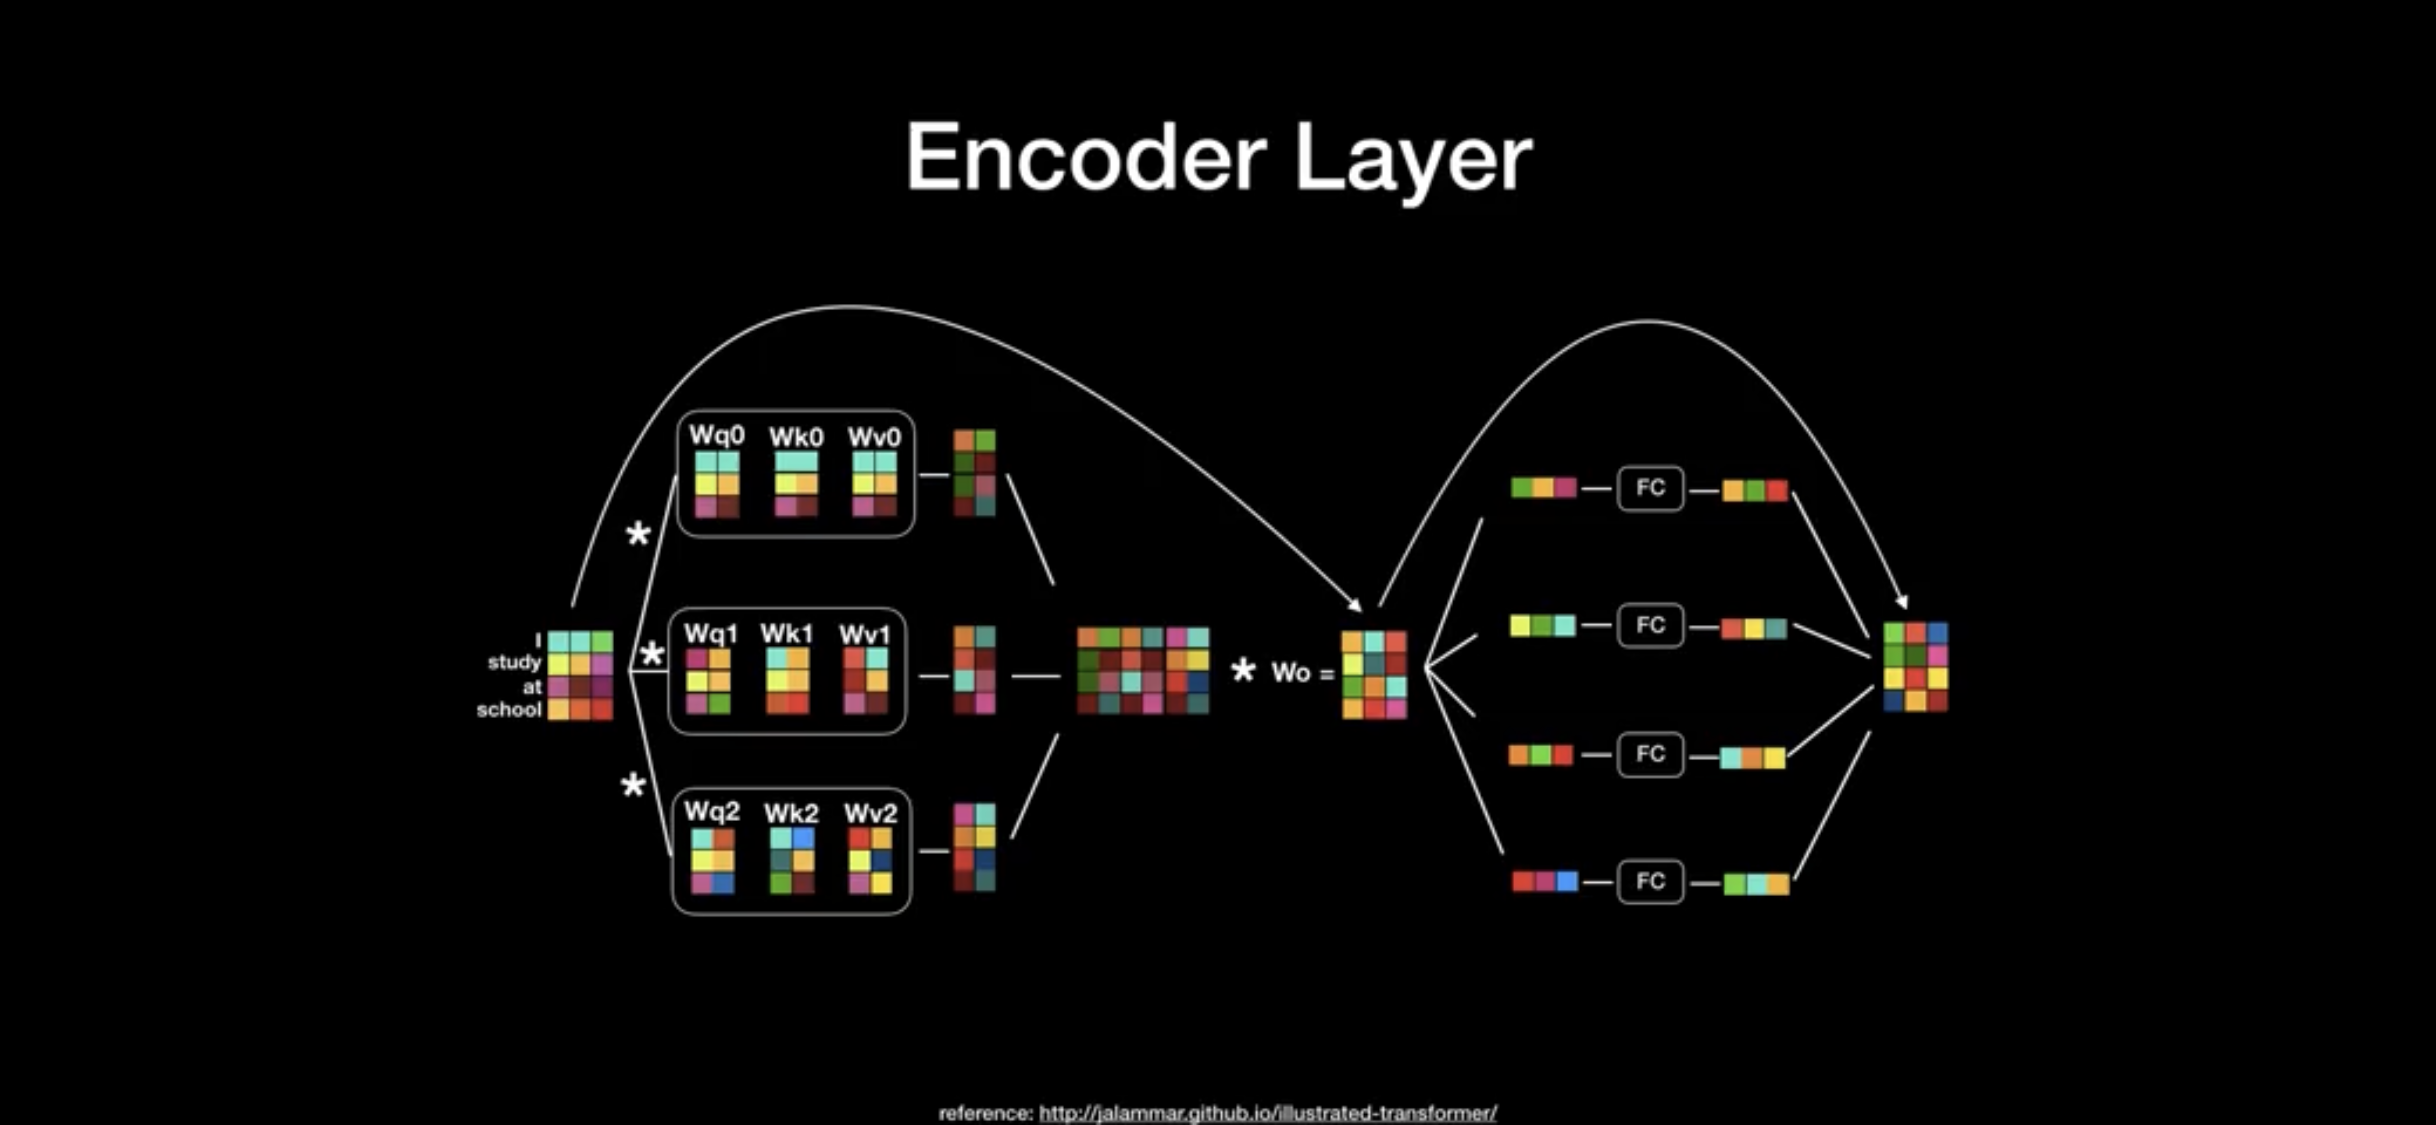

In [177]:
################### 인코더 각 층들 합쳐 반복하기 ####################
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")


    #padding mask
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    #embedding layer
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    #positional encoding layer
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    #num_layer만큼 encoder layer를 반복하여 쌓아줌
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
            )([outputs, padding_mask])

    return tf.keras.Model(
        inputs = [inputs, padding_mask], outputs = outputs, name = name
    )

print('인코더 만들기.... 진짜 끝...!!!')

인코더 만들기.... 진짜 끝...!!!


## 2. 디코더 층 만들기

### 1) 디코더 층 만들기
---
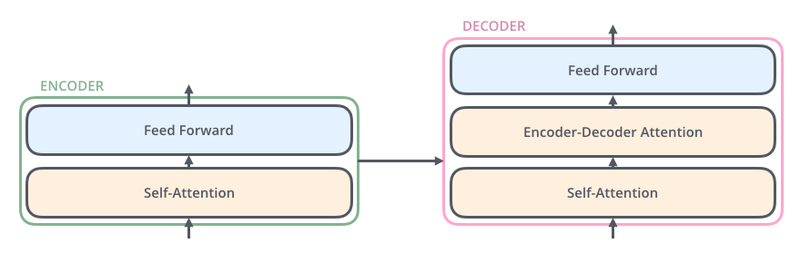
- 상기 그림은 디코더 층의 대략적인 모델로, 첫 번째는 셀프 어텐션, 두 번째는 인코더-디코더 어텐션, 세 번째는 피드 포워드 신경망으로 이뤄져 있음을 알 수 있음

- 디코더는 멀티헤드어텐션에서 인코더의 키와 벨류값을 받아 예측하는 것으로 인코더 모델과 차이가 있음  
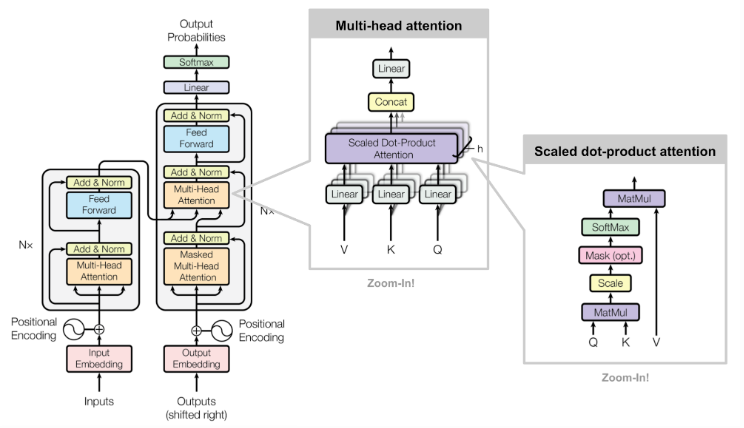

In [178]:
##################### 디코더 층 만들기 #####################
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape = (None, d_model), name = "inputs")
    enc_outputs = tf.keras.Input(shape = (None, d_model), name = "encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape = (1, None, None), name = "look_ahead_mask")
    padding_mask = tf.keras.Input(shape = (1, 1, None), name = 'padding_mask')

    #첫번째 layer : multi head attention
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
            })

    #어텐션 이후 normalization을 통해 학습을 돕는다
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    #두번째 layer : masked multi head attention
    #이 층은 인코더-디코더를 연결하여 예측하도록 도와줌
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs, # key와 value 값을 encoder에서 받아오는 것이 특징
            'value': enc_outputs,
            'mask': padding_mask
            })
    # Dropout과 normalization을 통해 학습을 돕는다
    attention2 = tf.keras.layers.Dropout(rate = dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon = 1e-6)(attention2 + attention1)

    #세번째 layer : 완전 연결층 
    outputs = tf.keras.layers.Dense(units = units, activation = 'relu')(attention2)
    outputs = tf.keras.layers.Dense(units = d_model)(outputs)

    # Dropout과 normalization을 통해 학습을 돕는다
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs = [inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs = outputs,
        name = name
    )

print('디코더층 완료!')


디코더층 완료!


### 2) 디코더 층을 쌓아 디코더 만들기 
---
- 이렇게 구현한 디코더의 층은 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성됨
- 인코더와 마찬가지로 `num_layers`를 정하여 원하는 횟수만큼 학습시킬 수 있음

In [179]:
############ 디코더 층 합쳐 반복하기 ##################
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # padding mask
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # embedding layer
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    #positional encoding
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    #Dropout을 통해 학습을 돕는다
    outputs = tf.keras.layers.Dropout(rate = dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units = units,
            d_model = d_model,
            num_heads = num_heads,
            dropout = dropout,
            name = 'decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)
    
print('디코더 층 쌓기 완료~:)!')

디코더 층 쌓기 완료~:)!


## 3. 인코더층과 디코더층을 합쳐 트랜스포머 함수 만들기

In [180]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("트랜스포머 완성!!!!!!!!!!!!!!!!!!!!")

트랜스포머 완성!!!!!!!!!!!!!!!!!!!!


## 3. 모델 정의 및 학습하기
---
- 인코더와 디코더의 층의 개수
NUM_LAYERS = 2 
- 인코더와 디코더 내부의 입, 출력의 고정 차원
D_MODEL = 256 
- 멀티 헤드 어텐션에서의 헤드 수 
NUM_HEADS = 8 
- 피드 포워드 신경망의 은닉층의 크기
UNITS = 512 
- 드롭아웃의 비율
DROPOUT = 0.1

In [181]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size = VOCAB_SIZE,
    num_layers = NUM_LAYERS,
    units = UNITS,
    d_model = D_MODEL,
    num_heads = NUM_HEADS,
    dropout = DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3148288     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

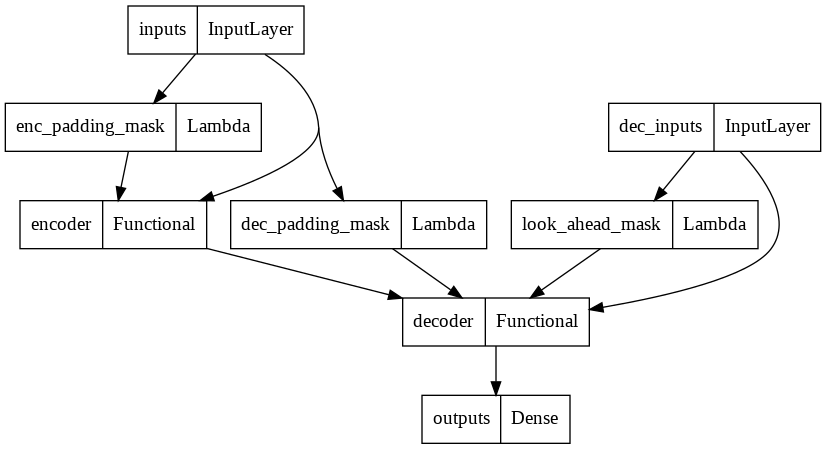

In [183]:
#모델 shape 확인
tf.keras.utils.plot_model(model, 'my_first_model.png')

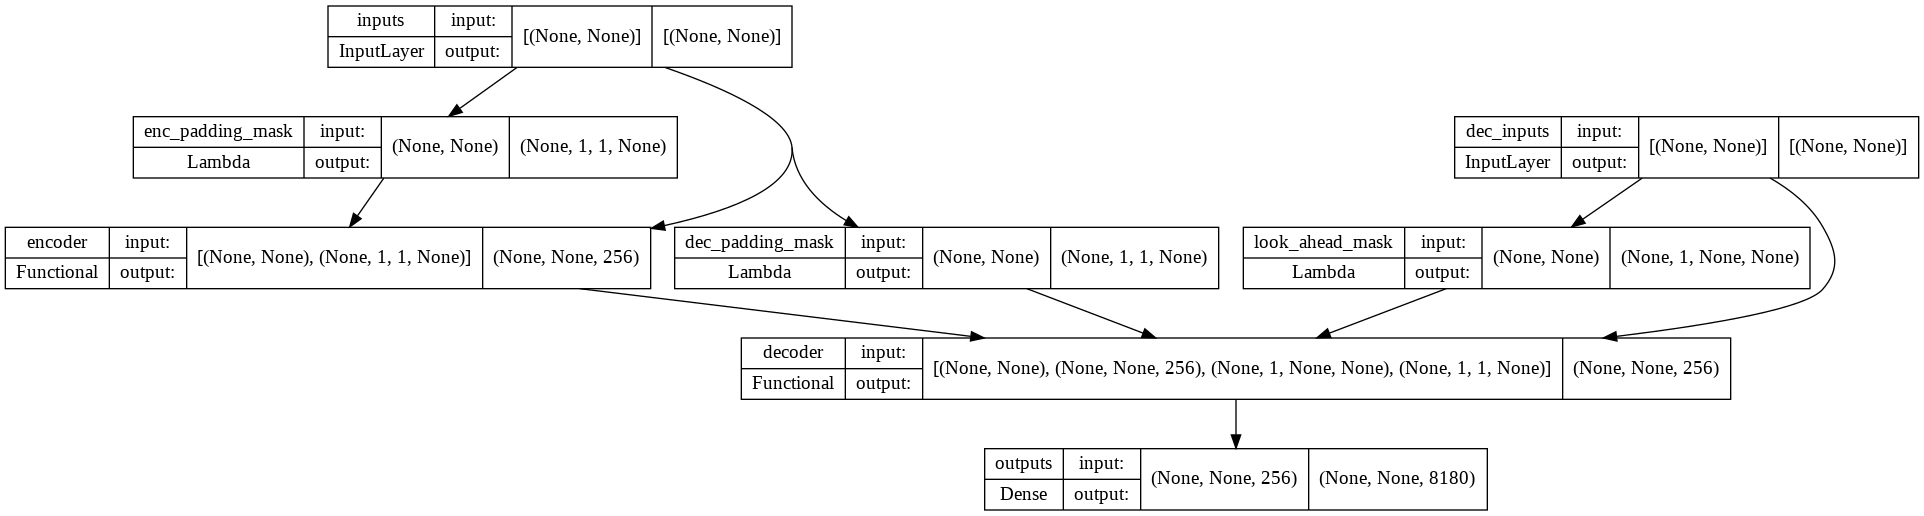

In [184]:
tf.keras.utils.plot_model(model, 'my_first_model_with_shape_info.png', show_shapes=True)

후하후하 힘들게 모델을 완성했습니다!!!ㅜㅜㅜ흑흑 내새끼ㅠㅠㅠㅠㅠ  

이제 학습을 시켜봅시다

아 그전에 loss 값도 다시 정해줘야죠!

### 4. loss 및 learning rate 정하기

- 먼저 그냥 일반 loss를 정해서 돌려주고,
- 이후 앞서 쓰기로한 label smoothing을 사용하여 loss 율을 비교해 보면 재밌을 것 같습니다!

`tf.keras.losses.BinaryCrossentropy( from_logits=False, label_smoothing=0, reduction=losses_utils.ReductionV2.AUTO, name='binary_crossentropy' )`

### 4-1) 일반 loss 

---

In [203]:
############# 손실함수 ##############
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LEN - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)
print('loss 함수 완료!')

loss 함수 완료!


#### 커스텀된 학습률
---
 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있다고 한다.   

학습된 스케줄러를 통한 Adam을 사용하자.

논문에 나온 공식은 다음과 같다.
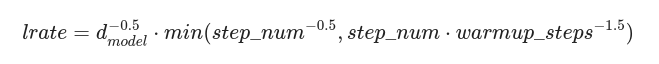

In [190]:
################# 학습률 커스텀하기 #####################
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

print('학습률 커스텀 완료!')

학습률 커스텀 완료!


Text(0.5, 0, 'Train Step')

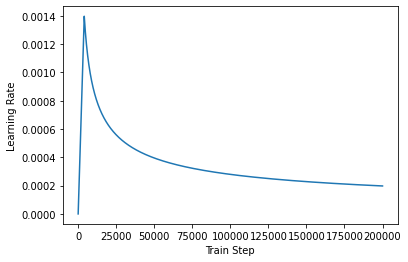

In [191]:
# 커스텀한 학습률 스케줄링 시각화해주기
sample_learning_rate = CustomSchedule(d_model = 128)

plt.plot(sample_learning_rate(tf.range(200000, dtype = tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 모델 컴파일 하기!

In [204]:
###############모델 컴파일 ####################
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LEN - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model_1 = model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print('모델 컴파일 완료:)!')

모델 컴파일 완료:)!


### 대망의 훈련시키기!!!!

In [205]:
EPOCHS = 10

history_1 = model.fit(dataset, epochs = EPOCHS, verbose = 1)

Epoch 1/10
185/185 [==============================] - 17s 42ms/step - loss: 2.8232 - accuracy: 0.0551
Epoch 2/10
185/185 [==============================] - 8s 43ms/step - loss: 2.2907 - accuracy: 0.0966
Epoch 3/10
185/185 [==============================] - 8s 42ms/step - loss: 1.9573 - accuracy: 0.0986
Epoch 4/10
185/185 [==============================] - 8s 42ms/step - loss: 1.8090 - accuracy: 0.1057
Epoch 5/10
185/185 [==============================] - 8s 42ms/step - loss: 1.6944 - accuracy: 0.1125
Epoch 6/10
185/185 [==============================] - 8s 42ms/step - loss: 1.5743 - accuracy: 0.1211
Epoch 7/10
185/185 [==============================] - 8s 42ms/step - loss: 1.4447 - accuracy: 0.1333
Epoch 8/10
185/185 [==============================] - 8s 42ms/step - loss: 1.3026 - accuracy: 0.1488
Epoch 9/10
185/185 [==============================] - 8s 42ms/step - loss: 1.1506 - accuracy: 0.1648
Epoch 10/10
185/185 [==============================] - 8s 42ms/step - loss: 0.9915 - accur

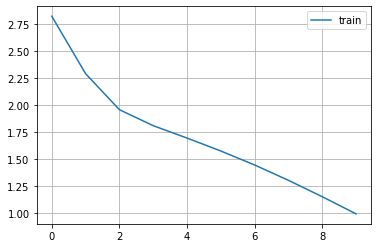

In [207]:
#시각화 하기
plt.plot(history_1.history['loss'], label='train')
plt.legend()
plt.grid()
plt.show()

오 loss가 0.9 까지 떨어지고, 정확도가 0.18 정도까지 나왔네요! 과연 뭐라고 예측할지 궁금합니다!

## Step 5. 모델 평가하기

---
`decoder_inference()` 함수를 만들어 챗봇의 대답을 이끌어내봅시다!


In [212]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장.
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LEN):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

print("챗봇 inference 완료:^)")

챗봇 inference 완료:^)


In [210]:
#################inference 함수를 사용하여 대답하는 함수 만들기#################
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('질문 : {}'.format(sentence))
    print('대답 : {}'.format(predicted_sentence))

    return predicted_sentence
    
print('챗봇 대답끌어내기 준비 완료>_<!')

챗봇 대답끌어내기 준비 완료>_<!


In [213]:
############# 답변 받아보기 ##################
sentence_generation('심심하다. 집에 가고싶다.')

질문 : 심심하다. 집에 가고싶다.
대답 : 저도 좋아해요 .


'저도 좋아해요 .'